# Writing a training loop from scratch.

With following code I aim to recreate the Pytorch nn.model and write all training code from scratch only using basic numpy stuff.  The goal is to understand pytorch at deeper level and therefore to be able to customize the training in any way I wish.  I am utilizing fast.ai as referefence and in fact I am working through their lesson.  Some of the code comes directly from fast.ai although I attempt to write everything from scratch only occationally referring to the way they did things as a sanity check.

## imports

In [1]:
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

## Getting the MNIST data

In [2]:
#Get MNIST data
MNIST_PATH='D:\\pytorch from scartch\data\\'
MNIST_FILE = MNIST_PATH + "mnist.pkl.gz"
print (MNIST_FILE)

D:\pytorch from scartch\data\mnist.pkl.gz


In [3]:
with gzip.open(MNIST_FILE, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

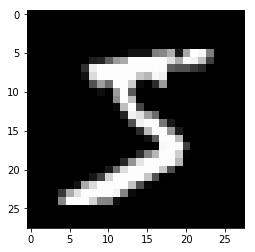

In [5]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
plt.imshow(img.view((28,28)));

Writing the above into functions...

In [6]:
def get_data():
    with gzip.open(MNIST_FILE, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In [7]:
x_train,y_train,x_valid,y_valid = get_data()

## How fast is matrix multiplication in python

In [ ]:
a = torch.randn(3,4)
b = torch.rand(4,3)

An ordinary python way of writing matrix multiplication.  It has a horrible tripple nested for loop! We will use pytorch tricks such as broadcasting to simplify it.

In [ ]:
def matmul_1(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br, "row size, colun size mismatch"
    c = torch.zeros(ar,bc)
    for i in range (ar):
        for j in range (bc):
            for k in range (ac):
                c[i][j] += a[i][k]*b[k][j]
    return c

In [ ]:
%time matmul_1(a,b)

In [ ]:
print (a)
print(b)
print(a[1,:])
print(b[:,0])
print (a[1,:]*b[:,0])
print ((a[1,:]*b[:,0]).sum())

The next version eliminates one of the nested loops by using pytorch .sum that runs considerably faster.

In [ ]:
def matmul_2(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br, "row size, colun size mismatch"
    c = torch.zeros(ar,bc)
    for i in range (ar):
        for j in range (bc):
            c[i][j] = (a[i,:]*b[:,j]).sum()
    return c

In [ ]:
%time matmul_2(a,b)

In [ ]:
a = torch.randn(3,4)
b = torch.rand(4,3)
print (a)
print(b)
print (a[1].unsqueeze(-1))
c = torch.zeros(3,3)
c[1]   = (a[1].unsqueeze(-1) * b).sum(dim=0)
print (c)

Next we use full power of broadcasting to eliminate the second for loop.

In [ ]:
def matmul_3(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br, "row size, colun size mismatch"
    c = torch.zeros(ar,bc)
    for i in range (ar):
        c[1]   = (a[1].unsqueeze(-1) * b).sum(dim=0)
    return c

In [ ]:
%time matmul_3(a,b)

Behind the scenes pytorch is using BLAS library to increase the speed to C speed.

As a final comparison let us compare this to pytorch @ operator.

In [ ]:
%time a@b

## Weights
set up some random weights and biases.  We will see later how these will have to be randomized in a better way to get a good std and mean.

In [ ]:
weights = torch.randn(784,10)

In [ ]:
weights.shape

We have 10 bias values

In [ ]:
bias = torch.zeros(10) 

In [ ]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

In [ ]:
%timeit -n 10 _=matmul_1(m1, m2)
%timeit -n 10 _=matmul_2(m1, m2)
%timeit -n 10 _=matmul_3(m1, m2)

## Einstein summation notation

In [ ]:
def einstein_matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [ ]:
%timeit -n 10 _=einstein_matmul(m1,m2)

In [ ]:
%timeit -n 10 _=einstein_matmul(m1,m2)
%timeit -n 10 _=m1@m2

Conclusion: @ is fastest because it uses libraries that ultimately compute with C speed or cuda speed.

 We have 24*24 = 784 inputs and we have 10 outputs for the 10 classes.

## Forward and backward passes

### Normalize data

In [27]:
#this is used to normalize data
def z_score(x,m,s): return (x-m)/s
normalize = z_score

In [ ]:
x_train_mean = x_train.mean()
x_train_std = x_train.std()

x_valid_mean = x_valid.mean()
x_valid_std = x_valid.std()

In [ ]:
print (x_train_mean, x_train_std,x_valid_mean,x_valid_std)

In [ ]:
x_train = normalize(x_train, x_train_mean, x_train_std)
x_valid = normalize(x_valid, x_valid_mean, x_valid_std)

In [ ]:
print (x_train_mean, x_train_std,x_valid_mean,x_valid_std)

### Define architecture

Note that ideally we would set this up as a classification problem and use cross entropy loss, but I am following the fast.ai course and this is what they want to do initially.

input is 28*28 = 784
50 hidden layers
1 output

So we will go:

784 -> 50 -> 1

This means we have:
Layer 1: input@weights1 + bias1 gives us a 50x1 vector.  Input is 1x786 We see that weights must be 786x50 and bias1 is 1x50.

Activation layer: Before passing to the output layer we have an activation layer.  This can be ReLu

Layer 2: We go 50->1. 


In [ ]:
input_size = 28 * 28
num_hidden = 50 

In [ ]:
weights1 = torch.randn(input_size, num_hidden)
bias1 = torch.zeros(1,50)
weights2 = torch.randn(50,1)
bias2 = torch.zeros(1)

Quick check that the pipeline is set up correctly

In [ ]:
input_data = torch.randn(1, input_size)
output_layer_1 = input_data @ weights1 + bias1

print("Layer 1 output shape:", output_layer_1.shape)

output_layer_2 = output_layer_1 @ weights2

print("Layer 2 output shape:", output_layer_2.shape)

Kaiming init: Properly randomizes the weights to have mean 0 std 1.  You need this because otherwise you will run into vanishing gradients or exploding gradients.

In [ ]:
# I will write the Kaiming initialization here

## Forward pass

In [ ]:
def ReLU(x):
    y = (x > 0)
    y = y.type(torch.FloatTensor)
    return x*y

In [ ]:
def lin(x, weights, bias):
    return x@weights + bias

In [ ]:
# test data
inp = torch.randn(1, input_size)
weights1 = torch.randn(input_size, num_hidden)
bias1 = torch.zeros(1,50)
weights2 = torch.randn(50,1)
bias2 = torch.zeros(1)

In [ ]:
m = 784
nh = 50
# simplified kaiming init / he init
weights1 = torch.randn(m,nh)/math.sqrt(m)
bias1 = torch.zeros(nh)
weights2 = torch.randn(nh,1)/math.sqrt(nh)
bias2 = torch.zeros(1)

In [ ]:
def forward_pass(inp, weights1, bias1, weights2, bias2):    
    lin1_out = lin(inp, weights1, bias1)
    relu_out = ReLU(lin1_out)
    lin2_out = lin(relu_out, weights2, bias2)
    
    return lin2_out

In [ ]:
preds = forward_pass(inp, weights1, bias1, weights2, bias2)

In [ ]:
preds.mean()

In [ ]:
preds.std()

## Loss function

In [ ]:
# MSE loss
def MSE(target, inp):
    return (target - inp).pow(2).mean()

In [ ]:
inp = x_train
preds = forward_pass(inp,weights1,bias1,weights2,bias2)
print(preds.shape)

In [ ]:
y_train,y_valid = y_train.float(),y_valid.float()
MSE(y_train,preds)

# Backward pass

Backward pass is all about the chain rule.  

Assume we have the following architecture:

$$\text{Input} \rightarrow L_1 \rightarrow L_2 \rightarrow \dots \rightarrow L_n \rightarrow \text Loss$$

It suffices to look at a layer $L$.  We assume this is some layer in the middle.  It has an input $x$ which is a vector (more generally a tensor, but let us consider the vector case since the generalizationis trivial.) of size $k$ and output is a vector of size $l$.  We can consider how the loss $f$ changes as a function of the output of $L$.  Note that we can define the loss function to be $F$ to be the composition of all layers after L and the final loss function $f$.  This gives us the ability to view $L$ as the last layer before the loss.  We define the input to $L$ to be $x$. We now want to know how the parameters of $L$ should be adjusted to minimize the loss. Let us compute with a concerete example.  We will take $L$ to be a linear layer with $3$ neurons and output of $2$ values.  To simplify things a bit I will ignore bias although it is easy to include it and it changes nothing.

The weight matrix $w$ is then a $3x2$ matrix. The loss with respect to the outputput of $L$ is:

$$F = F((f_1(x), f_2(x)))$$

Here $f_1(x) = x \cdot w_1$ where $w_1$ is first row of $w$ and $f_2(x) = x \cdot w_2$ where $w_2$ is the second row of w.

Lets denote $f_1(x)$ as $out_1$ and $f_2(x)$ as $out_2$.  Then the gradient of $F$ is $(\frac{\partial F}{\partial out_1}, \frac{\partial F}{\partial out_2})$.

This is used as layers out.g.  

$$\text{out.g} = (\frac{\partial F}{\partial out_1}, \frac{\partial F}{\partial out_2})$$

We can now ask what is out.g for the previous layer? This is the gradient of loss wrt output of the previous layer put through $L$.  The output of previous layer is a vector of dim $3$.

This is the gradient of the loss wrt to the input into $L$, $x = (x_1, x_2, x_3)$

This is $(\frac{\partial F}{\partial x_1}, \frac{\partial F}{\partial x_2}, \frac{\partial F}{\partial x_3})$.

Which in turn is:

$$\left(\frac{\partial F(f_1(x_1, x_2, x_3), f_2((x_1, x_2, x_3))}{\partial x_1}, \frac{\partial F(f_1(x_1, x_2, x_3), f_2((x_1, x_2, x_3))}{\partial x_2}, \frac{\partial F(f_1(x_1, x_2, x_3), f_2((x_1, x_2, x_3))}{\partial x_3}\right )$$

Let us write $g(x) = (f_1(x), f_2(x))$

Using the chain rule:

$$\left( out.g \cdot \frac{\partial g(x)}{\partial x_1}, out.g \cdot \frac{\partial g(x)}{\partial x_2}, out.g \cdot \frac{\partial g(x)}{\partial x_3} \right)$$

This can be written in the matrix form.  

$\begin{bmatrix}out.g_1 && out.g_2\end{bmatrix} \begin{bmatrix}\frac{\partial f_1(x)}{\partial x_1} && \frac{\partial f_1(x)}{\partial x_2} && \frac{\partial f_1(x)}{\partial x_3}\\\frac{\partial f_2(x)}{\partial x_1} && \frac{\partial f_2(x)}{\partial x_2} && \frac{\partial f_2(x)}{\partial x_3}\end{bmatrix}$

Note that $w = \begin{bmatrix}w_{11} && w_{12}\\ w_{21} && w_{22} \\ w_{31} && w_{32}  \end{bmatrix}$

Output of the linear layer (apart from the bias) is:

$$\begin{bmatrix} x_1 && x_2 && x_3 \end{bmatrix} \begin{bmatrix}w_{11} && w_{12}\\ w_{21} && w_{22} \\ w_{31} && w_{32}\end{bmatrix} = (x_1 w_{11} + x_2 w_{12} + x_3 w_{13}, x_1 w_{21} + x_2 w_{22} + x_3 w_{23}) = (f_1(x), f_2(x)) $$

We can immediately see that $\frac{\partial f_i(x)}{\partial x_j} = w_{ij}$

Hence we arrive at the important result:

$$\text{inp.g} = \text{out.g} @ w^T$$

Some important comments on inp.g:

- This inp.g is the out.g of the previous layer and can in turn be used to calculate its inp.g in similar manner.

- We calculate the gradients in reverse order always utilizing the next layers inp.g to calculate the inp.g for previous layer.

- For linear layer we can calculate the gradients for the weights and bias using the out.g

To calculate how to vary the parameters we need to calculate $\frac{\partial F}{\partial w_{ij}} = \frac{\partial F}{\partial out_1}\frac{\partial out_1}{\partial w_{ij}} + \frac{\partial F}{\partial out_2}\frac{\partial out_2}{\partial w_{ij}}$

$\frac{\partial out_1}{\partial w_{ij}} = 0$ if $i \neq 1$ similarly for $\frac{\partial out_2}{\partial w_{ij}}$ 

Let us consider $w_{1j}$.  Then $\frac{\partial F}{\partial w_{1j}} = \frac{\partial F}{\partial out_1}\frac{\partial out_1}{\partial w_{1j}}$

$\frac{\partial out_1}{\partial w_{1j}} = x_j$

So $\frac{\partial F}{\partial w_{1j}} = \frac{\partial F}{\partial out_1} \cdot x_j$ and $\frac{\partial F}{\partial w_{2j}} = \frac{\partial F}{\partial out_2} \cdot x_j$

This means that the $w.g$ matrix looks like:

\begin{bmatrix}x_1 \text{out}_1.g && x_1 \text{out}_2.g \\ x_2 \text{out}_1.g && x_2 \text{out}_2.g \\ x_3 \text{out}_1.g && x_3 \text{out}_2.g  \end{bmatrix}

This is inp.g broadcast in axis 1 entrywise multiplied by out.g: inp.unsqueeze(-1) * out.g.unsqueeze(1)

We can compute bias.g. We need to find $\frac{\partial F}{\partial b_1} = \frac{\partial F}{\partial out_1}\frac{\partial out_1}{\partial b_1}$

$\frac{\partial out_1}{\partial b_1} = 1$

So  $\frac{\partial F}{\partial b_1} = \frac{\partial F}{\partial out_1}$

Similarly $\frac{\partial F}{\partial b_2} = \frac{\partial F}{\partial out_2}$


We have the result:

$\text{bias.g} = out.g$

## Demo on how to implement w.g

In [ ]:
a_test= torch.randn(1,3)
print ("a_test: \n", a_test, "\n")

print ("a_test.unsqueeze(-1):\n", a_test.unsqueeze(-1))

print("------------------------------\n")

b_test = torch.rand(1,2)
print("b_test: \n",b_test)
print ("b_test.unsqueeze(1): \n", b_test.unsqueeze(1), "\n")

print("------------------------------\n")

print ("a_test.unsqueeze(-1) * b_test.unsqueeze(1): \n", a_test.unsqueeze(-1) * b_test.unsqueeze(1))

In [ ]:
# .sum(0) can be used to get rid of extra [ ]
print ("(a_test.unsqueeze(-1) * b_test.unsqueeze(1)).sum(0): \n", (a_test.unsqueeze(-1) * b_test.unsqueeze(1)).sum(0))

In [ ]:
#compute the gradient of loss wrt inp
def grad_MSE(target, inp):
    inp.g = 2. * (inp.squeeze() - target).unsqueeze(-1) / inp.shape[0]
    print("inp.g", inp.g)

In [ ]:
def grad_relu(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [ ]:
def grad_lin(inp, out, w, b):
    print("out.g", out.g)
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)
    print (b.g)

### Forward and backward pass

In [ ]:
def forward_and_backward_pass(inp, target, weights1, bias1, weights2, bias2):
    #forward pass
    lin1_out = lin(inp, weights1, bias1)
    relu_out = ReLU(lin1_out)
    lin2_out = lin(relu_out, weights2, bias2)
    #calling all gradients in reverse order
    grad_MSE(target, lin2_out)
    grad_lin(relu_out, lin2_out, weights2, bias2)
#    grad_relu(lin1_out,relu_out)
#    grad_lin(inp,lin1_out, weights1, bias1)
    
    

In [ ]:
forward_and_backward_pass(x_train, y_train, weights1, bias1, weights2, bias2)

## Refactoring

All of the above is bit clumsy.  We need nice classes to wrap everything in. 

In [120]:
class linear():
    def __init__(self, weights, bias):
        self.w = weights
        self.b = bias
        self.lr = .5
    def __call__(self, inp, target):
        self.inp = inp
        self.target = target
        self.out = self.inp @ self.w + self.b
        return self.out
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)
        # Adjust the weights and biases
        self.w -= self.w.g * self.lr
        self.b -= self.b.g * self.lr

In [121]:
class ReLu():
    def __call__(self, inp, target):
        self.inp = inp
        self.out = inp.clamp_min(0.)-0.5
        return self.out
    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [122]:
class MSE():
    def __call__(self,inp, target):
        self.inp = inp
        self.targ = target
        self.out = (inp.squeeze() - target).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [123]:
class model():
    def __init__(self, layers, loss_function_class):
        self.layers = layers
        self.loss_function = loss_function_class()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x, targ)
        self.loss = self.loss_function(x, targ)
        return x
    
    def backward(self):
        self.loss_function.backward()
        for l in reversed(self.layers): l.backward()
    def zero_grad(self):
        for l in self.layers:
            if hasattr(l, 'w'):
                l.w.g.zero_()
                l.b.g.zero_()

## Get data and normalize it

In [66]:
nh = 50

x_train,y_train,x_valid,y_valid = get_data()

n,a = x_train.shape

print (n,a)

50000 784


In [67]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [68]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [69]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(-7.6999e-06), tensor(1.))

In [70]:
y_train, y_valid = y_train.float(),y_valid.float()

## Initialize weights and use Kaiming init

In [ ]:
# simplified kaiming init / he init
weights1 = torch.randn(a,nh)/math.sqrt(a)
bias1 = torch.zeros(nh)
weights2 = torch.randn(nh,1)/math.sqrt(nh)
bias2 = torch.zeros(1)

weights1.g,bias1.g,weights2.g,bias2.g = [None]*4


## Create the model

In [ ]:
m = model([linear(weights1,bias1), ReLu(), linear(weights2,bias2)], MSE)

x_train = x_train.float()
y_train = y_train.float()

Time test the forward pass

In [ ]:
%time loss = m(x_train, y_train)

Time test the backward pass

In [ ]:
%time m.backward()

# Cross entropy

In the improved architecture we want to use cross entropy for classification.  We start by building softmax, negative log loss and computing gradient for cross entropy loss

### Softmax

Idea is to turn the output of the nn into a probaility distribution.  One way to do this is with softmax.  For vector $X = (x_i)$
    
  $$Sm_i(X) = \frac{e^{x_i}}{\sum e^{x_j}} $$
  .
  
  

In [89]:
def my_softmax(x):
    return x.exp() / x.exp().sum(-1, keepdim = True)

In [90]:
def softmax(x):
    return torch.nn.Softmax(1)(x)

## log softmax

log softmax is just $\ln Sm_i$.

In [ ]:
# def log_softmax(x):
#    return (x.exp() / x.exp().sum(-1, keepdim = True)).log()

Lets use some exponential tricks to make this more computable

$$\ln Sm_i = x_i - \ln \sum e^{x_j}$$

In [ ]:
#def log_softmax(x):
#    return x - x.exp().sum(-1, keepdim = True).log()

Common trick to make this more computable is to factor out the max power m to reduce the magnitude of the exponents.

$$\ln Sm_i = x_i - \ln e^m \sum e^{x_j-m}$$
$$\ln Sm_i = x_i - m + \ln \sum e^{x_j-m}$$

In [85]:
def log_softmax(x):
    m = x.max(-1)[0]
    return x - m[:,None] - (x-m[:,None]).exp().sum(-1, keepdim = True).log()

In [91]:
softmax(preds)

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

## Cross entropy loss

Given a prediction $p = (p_i)$ and a one hot encoded target $y = (0, ..., 1, ..., 0)$ with 1 occuring in the ith slot. Cross entropy loss is defined as:

$$\text{loss} = -y \cdot \ln p$$

Of course here $p_i$ is just $Sm_i$

so

$$\text{loss} = -\sum y_i\ln Sm_i$$

or

$$\text{loss} = -\sum y_i(x_i + \ln \sum e^{x_j})$$


## Gradient of cross entropy loss

From the above we can compute 

$$\frac{\partial \text{loss}}{\partial x_i } = -y_i +\frac{1}{\sum e^{x_j}} \cdot e^{x_i}$$

or

$$\frac{\partial \text{loss}}{\partial x_i } = -y_i + Sm_i$$

#### Discussion on how to implement cross entropy and how to implement the gradient of cross entropy

torch has a number of indexing trics that are helpful. Namely we can index one tensor with another.  Consider the following set up:

In [ ]:
a_sample = torch.randn(2,10)
b_sample = torch.randint(0,9,[2])
print (a_sample)
print(b_sample)

We will now index a_sample by the indeces of b_sample.  First we list the rows where we want to grab corresponding entries as indexed by b_sample.

In [ ]:
a_sample[range(b_sample.shape[0]), b_sample]

This leads us to writing a cross entropy function:

In [21]:
def cross_entropy(inp, targ):
    lsm = log_softmax(inp)
    loss = -lsm[range(targ.shape[0]), targ].mean()     
    return loss

In [22]:
def grad_cross_entropy(inp, targ):
    grad = softmax(inp)
    grad[range(targ.shape[0]),targ] -= 1

    return grad/targ.shape[0]

## Cross entropy class

In [119]:
class cross_entropy_class:
    def softmax(self,x):
        return torch.nn.Softmax(1)(x)
    
    def log_softmax(self,x):
        m = x.max(-1)[0]        
        return self.softmax(x).log()
    
    def grad_cross_entropy(self):
        grad = self.softmax(self.inp)
        grad[range(self.targ.shape[0]),self.targ] -= 1
        grad /= self.targ.shape[0]
        return grad
        

    
    def __call__(self,inp, targ):
        self.inp = inp
        self.targ = targ
        lsm = self.log_softmax(inp)
        self.out = -lsm[range(self.targ.shape[0]), self.targ].mean()    
     
        return self.out
    
    def backward(self):
        self.inp.g = self.grad_cross_entropy()  

#### Test that our cross entropy function is the same as pytorch cross entropy

In [72]:
import torch
import torch.nn as nn
from torch.autograd import Variable

a_pred = Variable(torch.randn(1,4))

b_target = Variable(torch.LongTensor([3]))

criterion = nn.CrossEntropyLoss()
loss = criterion(a_pred, b_target)
print(loss)

print(cross_entropy(a_pred, b_target))



tensor(0.4181)
tensor(0.4181)


# Training loop

Anatomy of the loop:

loop for number of epocs
- get data batch
- run forward pass
- evaluate loss
- run backward pass
- zero gradients

# Set up model for using cross entropy

In [124]:
#batch size
bs = 64

In [125]:
# data
x_train,y_train,x_valid,y_valid = get_data()

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_valid_mean = x_valid.mean()
x_valid_std = x_valid.std()

x_train = normalize(x_train, x_train_mean, x_train_std)
x_valid = normalize(x_valid, x_valid_mean, x_valid_std)

y_train, y_valid = y_train.long(),y_valid.long()

In [126]:
#layer dimensions
nh = 50
out = 10
n,a = x_train.shape
print(n,a)

50000 784


In [127]:
# simplified kaiming init / he init
weights1 = torch.randn(a,nh)/math.sqrt(a)
bias1 = torch.zeros(nh)
weights2 = torch.randn(nh,out)/math.sqrt(nh)
bias2 = torch.zeros(out)

weights1.g,bias1.g,weights2.g,bias2.g = [None]*4

In [128]:
m = model([linear(weights1,bias1), ReLu(), linear(weights2,bias2)], cross_entropy_class)

In [129]:
x_batch = x_train[0:bs]
y_batch = y_train[0:bs]

preds = m(x_batch,y_batch)
preds.shape

torch.Size([64, 10])

## The training loop

In [137]:
eps = 10
# lr is in the model
for epoch in range(eps):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = m(xb,yb)
        m.backward()
        print(m.loss)
        m.zero_grad()



tensor(0.4403)
tensor(0.2423)
tensor(0.4919)
tensor(0.4305)
tensor(0.3892)
tensor(0.3687)
tensor(0.4077)
tensor(0.8918)
tensor(0.2169)
tensor(0.5242)
tensor(0.3559)
tensor(0.3692)
tensor(0.3757)
tensor(0.5537)
tensor(0.4610)
tensor(0.7865)
tensor(0.8180)
tensor(1.1192)
tensor(0.9311)
tensor(0.8903)
tensor(0.4000)
tensor(2.4635)
tensor(0.7714)
tensor(0.5598)
tensor(0.9321)
tensor(0.6408)
tensor(0.3859)
tensor(0.2593)
tensor(0.7451)
tensor(0.3867)
tensor(0.3006)
tensor(0.4366)
tensor(0.6334)
tensor(0.2431)
tensor(0.4199)
tensor(0.2461)
tensor(0.3901)
tensor(0.7425)
tensor(0.1749)
tensor(0.4529)
tensor(0.5977)
tensor(0.5280)
tensor(0.6814)
tensor(0.7721)
tensor(0.3884)
tensor(0.2402)
tensor(0.3982)
tensor(0.5785)
tensor(0.4015)
tensor(0.2919)
tensor(0.8521)
tensor(0.3049)
tensor(0.4475)
tensor(0.3182)
tensor(0.6220)
tensor(0.6808)
tensor(0.2259)
tensor(0.5868)
tensor(0.3687)
tensor(0.3768)
tensor(0.2282)
tensor(0.1955)
tensor(0.5453)
tensor(0.2480)
tensor(0.6251)
tensor(0.5161)
tensor(0.5

tensor(0.3958)
tensor(0.4844)
tensor(0.3491)
tensor(0.4509)
tensor(0.5640)
tensor(0.3115)
tensor(0.2275)
tensor(0.4709)
tensor(0.5025)
tensor(0.4470)
tensor(0.5092)
tensor(0.2340)
tensor(0.1465)
tensor(0.2245)
tensor(0.2141)
tensor(0.5462)
tensor(0.4114)
tensor(0.4877)
tensor(0.5266)
tensor(0.4527)
tensor(0.4755)
tensor(0.4315)
tensor(0.3412)
tensor(0.3329)
tensor(0.2380)
tensor(0.3101)
tensor(0.1266)
tensor(0.1311)
tensor(0.4558)
tensor(0.4366)
tensor(0.3538)
tensor(0.4262)
tensor(0.3635)
tensor(0.5003)
tensor(0.4669)
tensor(0.1377)
tensor(0.8250)
tensor(0.8647)
tensor(0.5966)
tensor(0.4997)
tensor(0.3685)
tensor(0.1480)
tensor(0.3686)
tensor(0.7688)
tensor(0.3321)
tensor(0.3809)
tensor(0.3608)
tensor(0.3114)
tensor(0.4004)
tensor(0.2276)
tensor(0.2777)
tensor(0.2966)
tensor(0.2505)
tensor(0.3536)
tensor(0.4576)
tensor(0.3260)
tensor(0.4097)
tensor(0.5535)
tensor(0.3281)
tensor(0.2500)
tensor(0.1678)
tensor(0.1772)
tensor(0.1516)
tensor(0.2324)
tensor(0.1470)
tensor(0.3395)
tensor(0.3

tensor(0.3302)
tensor(0.1428)
tensor(0.1758)
tensor(0.2705)
tensor(0.0683)
tensor(0.5755)
tensor(0.2071)
tensor(0.3547)
tensor(0.0571)
tensor(0.0718)
tensor(0.1406)
tensor(0.3939)
tensor(0.2648)
tensor(0.4890)
tensor(0.5874)
tensor(0.1681)
tensor(0.4486)
tensor(0.5346)
tensor(0.2948)
tensor(0.2942)
tensor(0.1853)
tensor(0.3267)
tensor(0.2497)
tensor(0.2770)
tensor(0.2322)
tensor(0.1454)
tensor(0.2265)
tensor(0.6396)
tensor(0.4293)
tensor(0.5424)
tensor(0.1512)
tensor(0.0886)
tensor(0.3398)
tensor(0.4149)
tensor(0.1829)
tensor(0.4652)
tensor(0.2823)
tensor(0.7618)
tensor(0.3400)
tensor(0.0341)
tensor(0.1641)
tensor(0.4668)
tensor(0.9231)
tensor(0.6437)
tensor(0.3686)
tensor(0.2625)
tensor(0.2698)
tensor(0.2219)
tensor(0.0465)
tensor(0.3539)
tensor(0.3382)
tensor(0.3565)
tensor(0.3780)
tensor(0.1862)
tensor(0.0518)
tensor(0.4976)
tensor(0.1568)
tensor(0.1991)
tensor(0.3411)
tensor(0.1935)
tensor(0.5389)
tensor(0.2756)
tensor(0.5127)
tensor(0.1893)
tensor(0.3620)
tensor(0.3841)
tensor(0.1

tensor(0.1669)
tensor(0.2636)
tensor(0.2368)
tensor(0.3832)
tensor(0.2906)
tensor(0.1648)
tensor(0.3724)
tensor(0.3556)
tensor(0.4329)
tensor(0.2760)
tensor(0.3580)
tensor(0.1587)
tensor(0.1768)
tensor(0.4271)
tensor(0.3609)
tensor(0.4074)
tensor(0.2130)
tensor(0.2299)
tensor(0.3010)
tensor(0.2414)
tensor(0.0538)
tensor(0.1328)
tensor(0.0545)
tensor(0.2510)
tensor(0.1321)
tensor(0.1852)
tensor(0.3775)
tensor(0.4104)
tensor(0.1408)
tensor(0.1402)
tensor(0.2507)
tensor(0.1158)
tensor(0.1997)
tensor(0.4920)
tensor(0.5119)
tensor(0.7799)
tensor(0.2615)
tensor(0.1729)
tensor(0.1663)
tensor(0.4002)
tensor(0.3890)
tensor(0.1612)
tensor(0.1055)
tensor(0.3163)
tensor(0.3179)
tensor(0.3002)
tensor(0.3411)
tensor(0.3155)
tensor(0.5539)
tensor(0.1914)
tensor(0.2313)
tensor(0.2053)
tensor(0.3047)
tensor(0.1390)
tensor(0.3234)
tensor(0.2694)
tensor(0.1931)
tensor(0.3477)
tensor(0.8095)
tensor(0.2860)
tensor(0.3601)
tensor(0.5374)
tensor(0.5787)
tensor(0.7841)
tensor(0.9555)
tensor(0.2830)
tensor(0.3

tensor(0.5485)
tensor(0.3893)
tensor(0.2660)
tensor(0.0975)
tensor(0.4534)
tensor(0.2082)
tensor(0.3666)
tensor(0.2668)
tensor(0.2418)
tensor(0.3134)
tensor(0.2741)
tensor(0.3653)
tensor(0.3362)
tensor(0.2584)
tensor(0.3172)
tensor(0.2272)
tensor(0.3294)
tensor(0.1269)
tensor(0.1681)
tensor(0.0872)
tensor(0.3658)
tensor(0.4031)
tensor(0.3262)
tensor(0.3653)
tensor(0.4009)
tensor(0.4414)
tensor(0.4553)
tensor(0.5942)
tensor(0.3694)
tensor(0.3748)
tensor(0.2177)
tensor(0.1068)
tensor(0.1820)
tensor(0.1920)
tensor(0.1827)
tensor(0.1904)
tensor(0.2708)
tensor(0.2758)
tensor(0.3274)
tensor(0.2260)
tensor(0.1080)
tensor(0.3491)
tensor(0.1887)
tensor(0.3416)
tensor(0.2384)
tensor(0.2697)
tensor(0.1422)
tensor(0.2254)
tensor(0.1740)
tensor(0.3823)
tensor(0.6775)
tensor(0.3613)
tensor(0.4064)
tensor(0.4464)
tensor(0.3600)
tensor(0.4478)
tensor(0.0516)
tensor(0.1875)
tensor(0.2582)
tensor(0.1776)
tensor(0.2962)
tensor(0.0425)
tensor(0.3317)
tensor(0.0324)
tensor(0.2410)
tensor(0.3256)
tensor(0.1

tensor(0.3386)
tensor(0.3705)
tensor(0.3707)
tensor(0.3826)
tensor(0.0740)
tensor(0.2783)
tensor(0.0578)
tensor(0.0518)
tensor(0.3956)
tensor(0.3691)
tensor(0.0932)
tensor(0.4191)
tensor(0.1330)
tensor(0.0862)
tensor(0.2375)
tensor(0.4797)
tensor(0.2725)
tensor(0.2213)
tensor(0.2490)
tensor(0.4413)
tensor(0.0630)
tensor(0.2860)
tensor(0.2103)
tensor(0.1761)
tensor(0.1872)
tensor(0.1593)
tensor(0.4186)
tensor(0.3713)
tensor(0.3420)
tensor(0.4333)
tensor(0.2429)
tensor(0.2105)
tensor(0.4769)
tensor(0.2303)
tensor(0.3599)
tensor(0.2675)
tensor(0.1586)
tensor(0.1213)
tensor(0.1065)
tensor(0.0560)
tensor(0.6694)
tensor(0.3434)
tensor(0.2792)
tensor(0.3128)
tensor(0.1752)
tensor(0.2453)
tensor(0.2860)
tensor(0.3039)
tensor(0.1944)
tensor(0.1437)
tensor(0.2666)
tensor(0.4617)
tensor(0.1057)
tensor(0.0187)
tensor(0.0748)
tensor(0.4878)
tensor(0.3199)
tensor(0.1700)
tensor(0.1088)
tensor(0.6508)
tensor(0.2100)
tensor(0.2690)
tensor(0.3172)
tensor(0.5263)
tensor(0.1500)
tensor(0.1419)
tensor(0.1

tensor(0.0985)
tensor(0.1802)
tensor(0.0758)
tensor(0.0869)
tensor(0.2083)
tensor(0.0924)
tensor(0.0348)
tensor(0.1568)
tensor(0.3280)
tensor(0.2304)
tensor(0.1360)
tensor(0.4984)
tensor(0.3437)
tensor(0.1114)
tensor(0.1384)
tensor(0.0521)
tensor(0.0672)
tensor(0.0262)
tensor(0.2886)
tensor(0.3188)
tensor(0.2953)
tensor(0.0785)
tensor(0.1733)
tensor(0.2449)
tensor(0.0739)
tensor(0.1191)
tensor(0.0232)
tensor(0.1341)
tensor(0.0208)
tensor(0.1798)
tensor(0.0567)
tensor(0.1156)
tensor(0.5331)
tensor(0.3245)
tensor(0.4766)
tensor(0.2094)
tensor(0.2166)
tensor(0.2447)
tensor(0.2615)
tensor(0.1772)
tensor(0.1820)
tensor(0.0668)
tensor(0.1740)
tensor(0.1075)
tensor(0.1892)
tensor(0.3190)
tensor(0.3805)
tensor(0.2153)
tensor(0.3504)
tensor(0.3216)
tensor(0.2194)
tensor(0.1641)
tensor(0.1574)
tensor(0.3187)
tensor(0.3007)
tensor(0.5615)
tensor(0.6821)
tensor(0.5853)
tensor(0.1463)
tensor(0.1373)
tensor(0.1866)
tensor(0.2410)
tensor(0.1380)
tensor(0.1784)
tensor(0.1183)
tensor(0.6287)
tensor(0.2

tensor(0.3142)
tensor(0.2238)
tensor(0.0914)
tensor(0.1069)
tensor(0.1088)
tensor(0.1705)
tensor(0.1331)
tensor(0.2748)
tensor(0.3638)
tensor(0.3255)
tensor(0.0825)
tensor(0.1428)
tensor(0.2585)
tensor(0.1044)
tensor(0.0525)
tensor(0.1547)
tensor(0.1784)
tensor(0.1809)
tensor(0.2865)
tensor(0.1878)
tensor(0.0922)
tensor(0.2576)
tensor(0.1137)
tensor(0.1212)
tensor(0.0695)
tensor(0.2060)
tensor(0.3061)
tensor(0.0691)
tensor(0.2261)
tensor(0.2867)
tensor(0.4191)
tensor(0.2549)
tensor(0.1151)
tensor(0.0558)
tensor(0.0775)
tensor(0.0880)
tensor(0.2561)
tensor(0.1806)
tensor(0.1246)
tensor(0.1389)
tensor(0.4053)
tensor(0.0640)
tensor(0.0918)
tensor(0.2434)
tensor(0.3557)
tensor(0.1444)
tensor(0.3278)
tensor(0.4462)
tensor(0.0874)
tensor(0.3606)
tensor(0.0970)
tensor(0.2383)
tensor(0.2526)
tensor(0.0775)
tensor(0.4596)
tensor(0.3057)
tensor(0.2484)
tensor(0.1969)
tensor(0.1019)
tensor(0.0383)
tensor(0.1738)
tensor(0.2538)
tensor(0.1388)
tensor(0.0587)
tensor(0.2364)
tensor(0.3261)
tensor(0.3

tensor(0.2861)
tensor(0.0548)
tensor(0.1352)
tensor(0.1000)
tensor(0.1271)
tensor(0.1540)
tensor(0.3114)
tensor(0.1321)
tensor(0.1692)
tensor(0.2986)
tensor(0.4414)
tensor(0.1338)
tensor(0.2035)
tensor(0.2499)
tensor(0.2237)
tensor(0.1920)
tensor(0.0928)
tensor(0.0994)
tensor(0.1387)
tensor(0.0261)
tensor(0.0946)
tensor(0.2875)
tensor(0.2188)
tensor(0.1445)
tensor(0.4367)
tensor(0.2277)
tensor(0.0854)
tensor(0.1184)
tensor(0.1230)
tensor(0.0703)
tensor(0.1381)
tensor(0.3710)
tensor(0.3552)
tensor(0.2042)
tensor(0.0669)
tensor(0.2331)
tensor(0.4990)
tensor(0.4702)
tensor(0.1528)
tensor(0.2606)
tensor(0.1422)
tensor(0.1907)
tensor(0.2489)
tensor(0.2876)
tensor(0.4124)
tensor(0.1677)
tensor(0.0840)
tensor(0.3893)
tensor(0.2966)
tensor(0.2039)
tensor(0.3525)
tensor(0.0174)
tensor(0.2835)
tensor(0.0430)
tensor(0.3319)
tensor(0.1567)
tensor(0.2715)
tensor(0.1226)
tensor(0.2233)
tensor(0.1686)
tensor(0.0778)
tensor(0.3050)
tensor(0.2322)
tensor(0.0845)
tensor(0.1188)
tensor(0.2275)
tensor(0.1

tensor(0.3724)
tensor(0.3380)
tensor(0.5995)
tensor(0.1051)
tensor(0.0929)
tensor(0.2141)
tensor(0.2858)
tensor(0.1848)
tensor(0.3666)
tensor(0.2376)
tensor(0.0701)
tensor(0.1803)
tensor(0.1359)
tensor(0.1668)
tensor(0.3375)
tensor(0.1612)
tensor(0.3615)
tensor(0.2155)
tensor(0.1849)
tensor(0.1500)
tensor(0.1917)
tensor(0.1401)
tensor(0.0263)
tensor(0.2760)
tensor(0.1981)
tensor(0.5733)
tensor(0.1342)
tensor(0.4581)
tensor(0.3442)
tensor(0.1151)
tensor(0.1632)
tensor(0.0610)
tensor(0.1747)
tensor(0.1214)
tensor(0.2227)
tensor(0.2207)
tensor(0.1105)
tensor(0.0949)
tensor(0.3696)
tensor(0.0751)
tensor(0.2225)
tensor(0.0639)
tensor(0.0966)
tensor(0.1109)
tensor(0.1629)
tensor(0.2424)
tensor(0.1911)
tensor(0.1851)
tensor(0.1245)
tensor(0.2457)
tensor(0.0637)
tensor(0.1207)
tensor(0.3928)
tensor(0.1572)
tensor(0.3063)
tensor(0.2247)
tensor(0.4911)
tensor(0.1168)
tensor(0.2243)
tensor(0.2279)
tensor(0.0983)
tensor(0.2003)
tensor(0.0984)
tensor(0.1622)
tensor(0.1849)
tensor(0.2126)
tensor(0.2

tensor(0.1422)
tensor(0.3122)
tensor(0.0865)
tensor(0.0548)
tensor(0.2762)
tensor(0.3414)
tensor(0.4219)
tensor(0.2485)
tensor(0.1882)
tensor(0.2351)
tensor(0.2836)
tensor(0.2415)
tensor(0.2626)
tensor(0.1047)
tensor(0.2740)
tensor(0.1679)
tensor(0.3940)
tensor(0.1255)
tensor(0.0461)
tensor(0.0589)
tensor(0.0690)
tensor(0.4732)
tensor(0.0156)
tensor(0.3842)
tensor(0.0594)
tensor(0.1041)
tensor(0.1038)
tensor(0.3445)
tensor(0.2797)
tensor(0.3240)
tensor(0.4212)
tensor(0.3961)
tensor(0.1066)
tensor(0.5626)
tensor(0.3419)
tensor(0.6262)
tensor(0.2029)
tensor(0.2430)
tensor(0.1392)
tensor(0.2350)
tensor(0.0709)
tensor(0.1147)
tensor(0.2454)
tensor(0.1848)
tensor(0.4232)
tensor(0.2491)
tensor(0.3717)
tensor(0.0774)
tensor(0.1722)
tensor(0.1329)
tensor(0.0447)
tensor(0.1622)
tensor(0.0251)
tensor(0.1040)
tensor(0.1781)
tensor(0.4004)
tensor(0.4957)
tensor(0.1863)
tensor(0.0550)
tensor(0.1323)
tensor(0.1895)
tensor(0.2904)
tensor(0.0436)
tensor(0.0117)
tensor(0.1042)
tensor(0.0572)
tensor(0.0

tensor(0.1777)
tensor(0.1611)
tensor(0.2435)
tensor(0.0127)
tensor(0.0301)
tensor(0.2773)
tensor(0.0998)
tensor(0.1112)
tensor(0.3066)
tensor(0.1438)
tensor(0.1983)
tensor(0.1020)
tensor(0.3823)
tensor(0.2171)
tensor(0.0505)
tensor(0.2256)
tensor(0.3290)
tensor(0.1868)
tensor(0.4353)
tensor(0.1175)
tensor(0.0642)
tensor(0.1516)
tensor(0.3373)
tensor(0.0977)
tensor(0.1972)
tensor(0.1069)
tensor(0.0895)
tensor(0.0342)
tensor(0.1516)
tensor(0.2012)
tensor(0.0592)
tensor(0.1347)
tensor(0.4621)
tensor(0.1329)
tensor(0.0550)
tensor(0.0770)
tensor(0.2100)
tensor(0.4297)
tensor(0.1750)
tensor(0.3378)
tensor(0.0838)
tensor(0.0946)
tensor(0.1484)
tensor(0.1738)
tensor(0.4838)
tensor(0.2227)
tensor(0.4697)
tensor(0.3649)
tensor(0.2387)
tensor(0.2299)
tensor(0.3235)
tensor(0.3629)
tensor(0.2542)
tensor(0.3107)
tensor(0.2717)
tensor(0.0788)
tensor(0.2793)
tensor(0.4342)
tensor(0.2906)
tensor(0.2344)
tensor(0.2280)
tensor(0.0696)
tensor(0.1082)
tensor(0.0272)
tensor(0.0623)
tensor(0.1750)
tensor(0.1

tensor(0.0587)
tensor(0.1734)
tensor(0.3999)
tensor(0.0710)
tensor(0.1604)
tensor(0.1461)
tensor(0.4091)
tensor(0.0954)
tensor(0.1825)
tensor(0.1017)
tensor(0.0439)
tensor(0.0101)
tensor(0.1291)
tensor(0.3006)
tensor(0.1517)
tensor(0.1372)
tensor(0.1738)
tensor(0.2298)
tensor(0.0213)
tensor(0.5226)
tensor(0.0829)
tensor(0.0706)
tensor(0.0525)
tensor(0.0367)
tensor(0.0774)
tensor(0.1116)
tensor(0.0575)
tensor(0.4726)
tensor(0.3794)
tensor(0.2456)
tensor(0.3362)
tensor(0.3186)
tensor(0.1918)
tensor(0.1823)
tensor(0.1430)
tensor(0.0473)
tensor(0.0383)
tensor(0.0627)
tensor(0.0504)
tensor(0.1829)
tensor(0.0204)
tensor(0.3130)
tensor(0.1026)
tensor(0.1371)
tensor(0.0729)
tensor(0.0146)
tensor(0.3530)
tensor(0.2558)
tensor(0.0135)
tensor(0.1138)
tensor(0.1608)
tensor(0.2849)
tensor(0.1515)
tensor(0.0103)
tensor(0.1132)
tensor(0.3709)
tensor(0.5000)
tensor(0.2294)
tensor(0.2765)
tensor(0.2142)
tensor(0.0609)
tensor(0.0865)
tensor(0.0240)
tensor(0.0984)
tensor(0.1428)
tensor(0.0547)
tensor(0.2

tensor(0.0425)
tensor(0.0363)
tensor(0.1648)
tensor(0.1071)
tensor(0.1748)
tensor(0.0282)
tensor(0.1309)
tensor(0.1915)
tensor(0.1023)
tensor(0.3321)
tensor(0.1070)
tensor(0.0476)
tensor(0.3353)
tensor(0.0884)
tensor(0.1509)
tensor(0.0204)
tensor(0.0445)
tensor(0.2814)
tensor(0.0955)
tensor(0.1688)
tensor(0.3336)
tensor(0.2015)
tensor(0.1162)
tensor(0.2188)
tensor(0.2445)
tensor(0.0066)
tensor(0.2323)
tensor(0.0622)
tensor(0.2498)
tensor(0.2385)
tensor(0.2208)
tensor(0.3252)
tensor(0.2657)
tensor(0.1457)
tensor(0.0190)
tensor(0.1528)
tensor(0.0695)
tensor(0.1171)
tensor(0.1141)
tensor(0.1258)
tensor(0.2737)
tensor(0.1269)
tensor(0.0160)
tensor(0.1619)
tensor(0.2006)
tensor(0.0154)
tensor(0.2971)
tensor(0.4240)
tensor(0.4881)
tensor(0.6967)
tensor(0.2221)
tensor(0.1781)
tensor(0.0927)
tensor(0.2923)
tensor(0.1499)
tensor(0.1029)
tensor(0.0243)
tensor(0.1866)
tensor(0.1757)
tensor(0.2367)
tensor(0.2280)
tensor(0.2427)
tensor(0.5291)
tensor(0.0781)
tensor(0.0376)
tensor(0.1428)
tensor(0.3

tensor(0.0181)
tensor(0.0965)
tensor(0.1088)
tensor(0.0840)
tensor(0.0095)
tensor(0.1517)
tensor(0.2366)
tensor(0.1206)
tensor(0.6431)
tensor(0.5497)
tensor(0.2703)
tensor(0.1553)
tensor(0.1672)
tensor(0.5227)
tensor(0.3114)
tensor(0.1591)
tensor(0.1769)
tensor(0.1121)
tensor(0.4954)
tensor(0.0328)
tensor(0.2292)
tensor(0.0904)
tensor(0.1729)
tensor(0.3115)
tensor(0.3391)
tensor(0.1421)
tensor(0.2912)
tensor(0.2160)
tensor(0.3303)
tensor(0.0788)
tensor(0.1726)
tensor(0.0956)
tensor(0.1218)
tensor(0.0618)
tensor(0.2294)
tensor(0.1823)
tensor(0.2145)
tensor(0.3119)
tensor(0.2429)
tensor(0.5763)
tensor(0.2361)
tensor(0.4114)
tensor(0.2555)
tensor(0.4175)
tensor(0.0822)
tensor(0.1534)
tensor(0.2342)
tensor(0.0698)
tensor(0.1104)
tensor(0.1046)
tensor(0.1708)
tensor(0.1589)
tensor(0.0677)
tensor(0.1106)
tensor(0.0631)
tensor(0.3173)
tensor(0.0880)
tensor(0.2422)
tensor(0.1276)
tensor(0.1632)
tensor(0.1411)
tensor(0.0426)
tensor(0.1567)
tensor(0.1673)
tensor(0.2721)
tensor(0.1845)
tensor(0.3

In [143]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [141]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
yb = y_train[0:bs]
preds = m(xb, yb)      # predictions
preds[0], preds.shape

(tensor([-18.6004,  12.7171,  -4.2211,  16.3589, -20.0163,  25.3055, -12.6226,
          -0.4316,  -3.1293,   6.2625]), torch.Size([64, 10]))

In [144]:
accuracy(preds, yb)

tensor(0.9375)